Copyright (c) 2020 Martin Holle. Alle Rechte vorbehalten. Lizensiert unter der MIT-Lizenz.


# Covid-19 Statistics Aachen: Datenvisualisierung

Die um vorherigen Schritt ermittelten Kennzahlen werden zunächst aus dem zur Zwischenspeicherung verwendeten Excel-Sheet eingelesen. Anschließend werdend die Kennzahlen in insgesamt 4 Diagrammen visualisiert:

**1. Diagramm: Covid-19-Fälle in der Städteregion Aachen**<br/>
Für die Städteregion Aachen werden die aktiven Fälle und die Summe der Genesenen und Todesfälle dargestellt.

**2. Diagramm: Änderung aktiver Fälle**<br/>
Für die Städteregion Aachen wird die Änderung der aktiven Fälle (absolut und prozentual, pro Tag und gemittelt) visualisiert.

**3. Diagramm: Neue Fälle / Genesene / Todesfälle**<br/>
Für die Städteregion Aachen werden die gemittelten Werte neuer Fälle, neuer Genesener und neuer Todesfälle dargestellt.

**4. Diagramm: Neuinfektionen in den letzten 7 Tagen pro 100.000 Einwohner**<br/>
Für die Städteregion und die Stadt Aachen wird die Summe der Neuinfektionen in den letzten 7 Tagen bezogen auf 100.000 Einwohner dargestellt.

## Benötigte Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd

import logging
import configparser
import os

# Konfiguration einlesen
config = configparser.ConfigParser()
config.read('config.ini')

# Konfiguration des Loggings
# - Die Logging-Ausgaben werden in der lokalen Datei covid-19-datenabfrage.log geschrieben
# - Für die Ausgabe wird eine bestimmte Formatierung konfiguriert
fhandler = logging.FileHandler(filename=config['Logging']['LogFileName'], mode='a')

# TODO: Formatierung finalisieren (Tausendstel-Sekunden, Tag des Monats, 1. Zeichen des Levels)
formatter = logging.Formatter('%(asctime)s %(levelname)-1.1s %(name)-20.20s - %(message)s')
fhandler.setFormatter(formatter)

# Instanzierung und Konfigurierung des Loggers
log = logging.getLogger("visualisierung")
log.addHandler(fhandler)
log.setLevel(logging.INFO)

## Grafikausgabe konfigurieren

In [2]:
# Konfiguration einlesen
config = configparser.ConfigParser()
config.read('config.ini')

Glättungsintervall = int(config['Kennzahlen']['Glaettung.Intervall'])

output_folder=config['Visualisierung']['OutputFolder']

# Vordefinierte Style, der benutzt werden soll
plt.style.use(config['Visualisierung']['PlotStyle'])

# Maße und Auflösung
fig_dpi = int(config['Visualisierung']['Figure.DPI'])
fig_width = int(config['Visualisierung']['Figure.Width'])
fig_height = int(config['Visualisierung']['Figure.Height'])

# Grundeinstellungen für das Diagramm-Layout
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titlepad'] = 10.0
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.borderpad'] = 1
mpl.rcParams['legend.borderaxespad'] = 1.5
mpl.rcParams['figure.figsize'] = fig_width, fig_height
mpl.rcParams['figure.dpi'] = fig_dpi
mpl.rcParams['savefig.dpi'] = fig_dpi
mpl.rcParams['savefig.bbox'] = 'tight'

# In bestimmten Diagrammen benutzte Farben (Maps)
color_map_rgb = [ "#0000dd", "#00dd00", "#dd0000" ]
color_map_named = [ "tab:blue", "tab:green", "tab:red" ]

## Vorverarbeitete Daten aus Excel-Datei einlesen

In [3]:
# Zwischenergebnisse aus Excel-Sheet einlesen
c19_cases = pd.read_excel(config['Kennzahlen']['FileName'], 
                          sheet_name=config['Kennzahlen']['SheetName'],
                          index_col=0,
                          parse_dates=[0])

## Hilfsfunktionen

In [4]:
def create_meta_file(filename: str, meta: {}, add_date: bool=False):
    """
    Create file with meta data in yml format.
    
    Parameters:
    ===========
    filename - File name for meta data file
    meta - Dictionary with meta data
    
    Returns:
    ========
    None
    """
    log.info("Meta data file created: {0}".format(filename))
    
    if add_date:
        pass # Automatisches Hinzufügen des aktuellen Datums hinzufügen
    
    with open(filename, "w") as file:
        for name, value in meta.items():
            file.write("{0}: {1}\n----\n".format(name, value))

## 1. Diagramm: Covid-19-Fälle in der Städteregion Aachen

Für die Städteregion Aachen (nur dafür liegen alle benötigten Rohdaten vor), werden die aktiven Fälle und die Summe der Genesenen und Todesfälle dargestellt:

- Eine X-Achse: Zeitachse
- Als Y-Achse der gestapelte Verlauf der absoluten Anzahl kummulierter Fälle (von unten nach oben):
    - Aktive Fälle
    - Summe genesen
    - Summe Todesfälle
- Verwendung `df.plot.area()`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.area.html

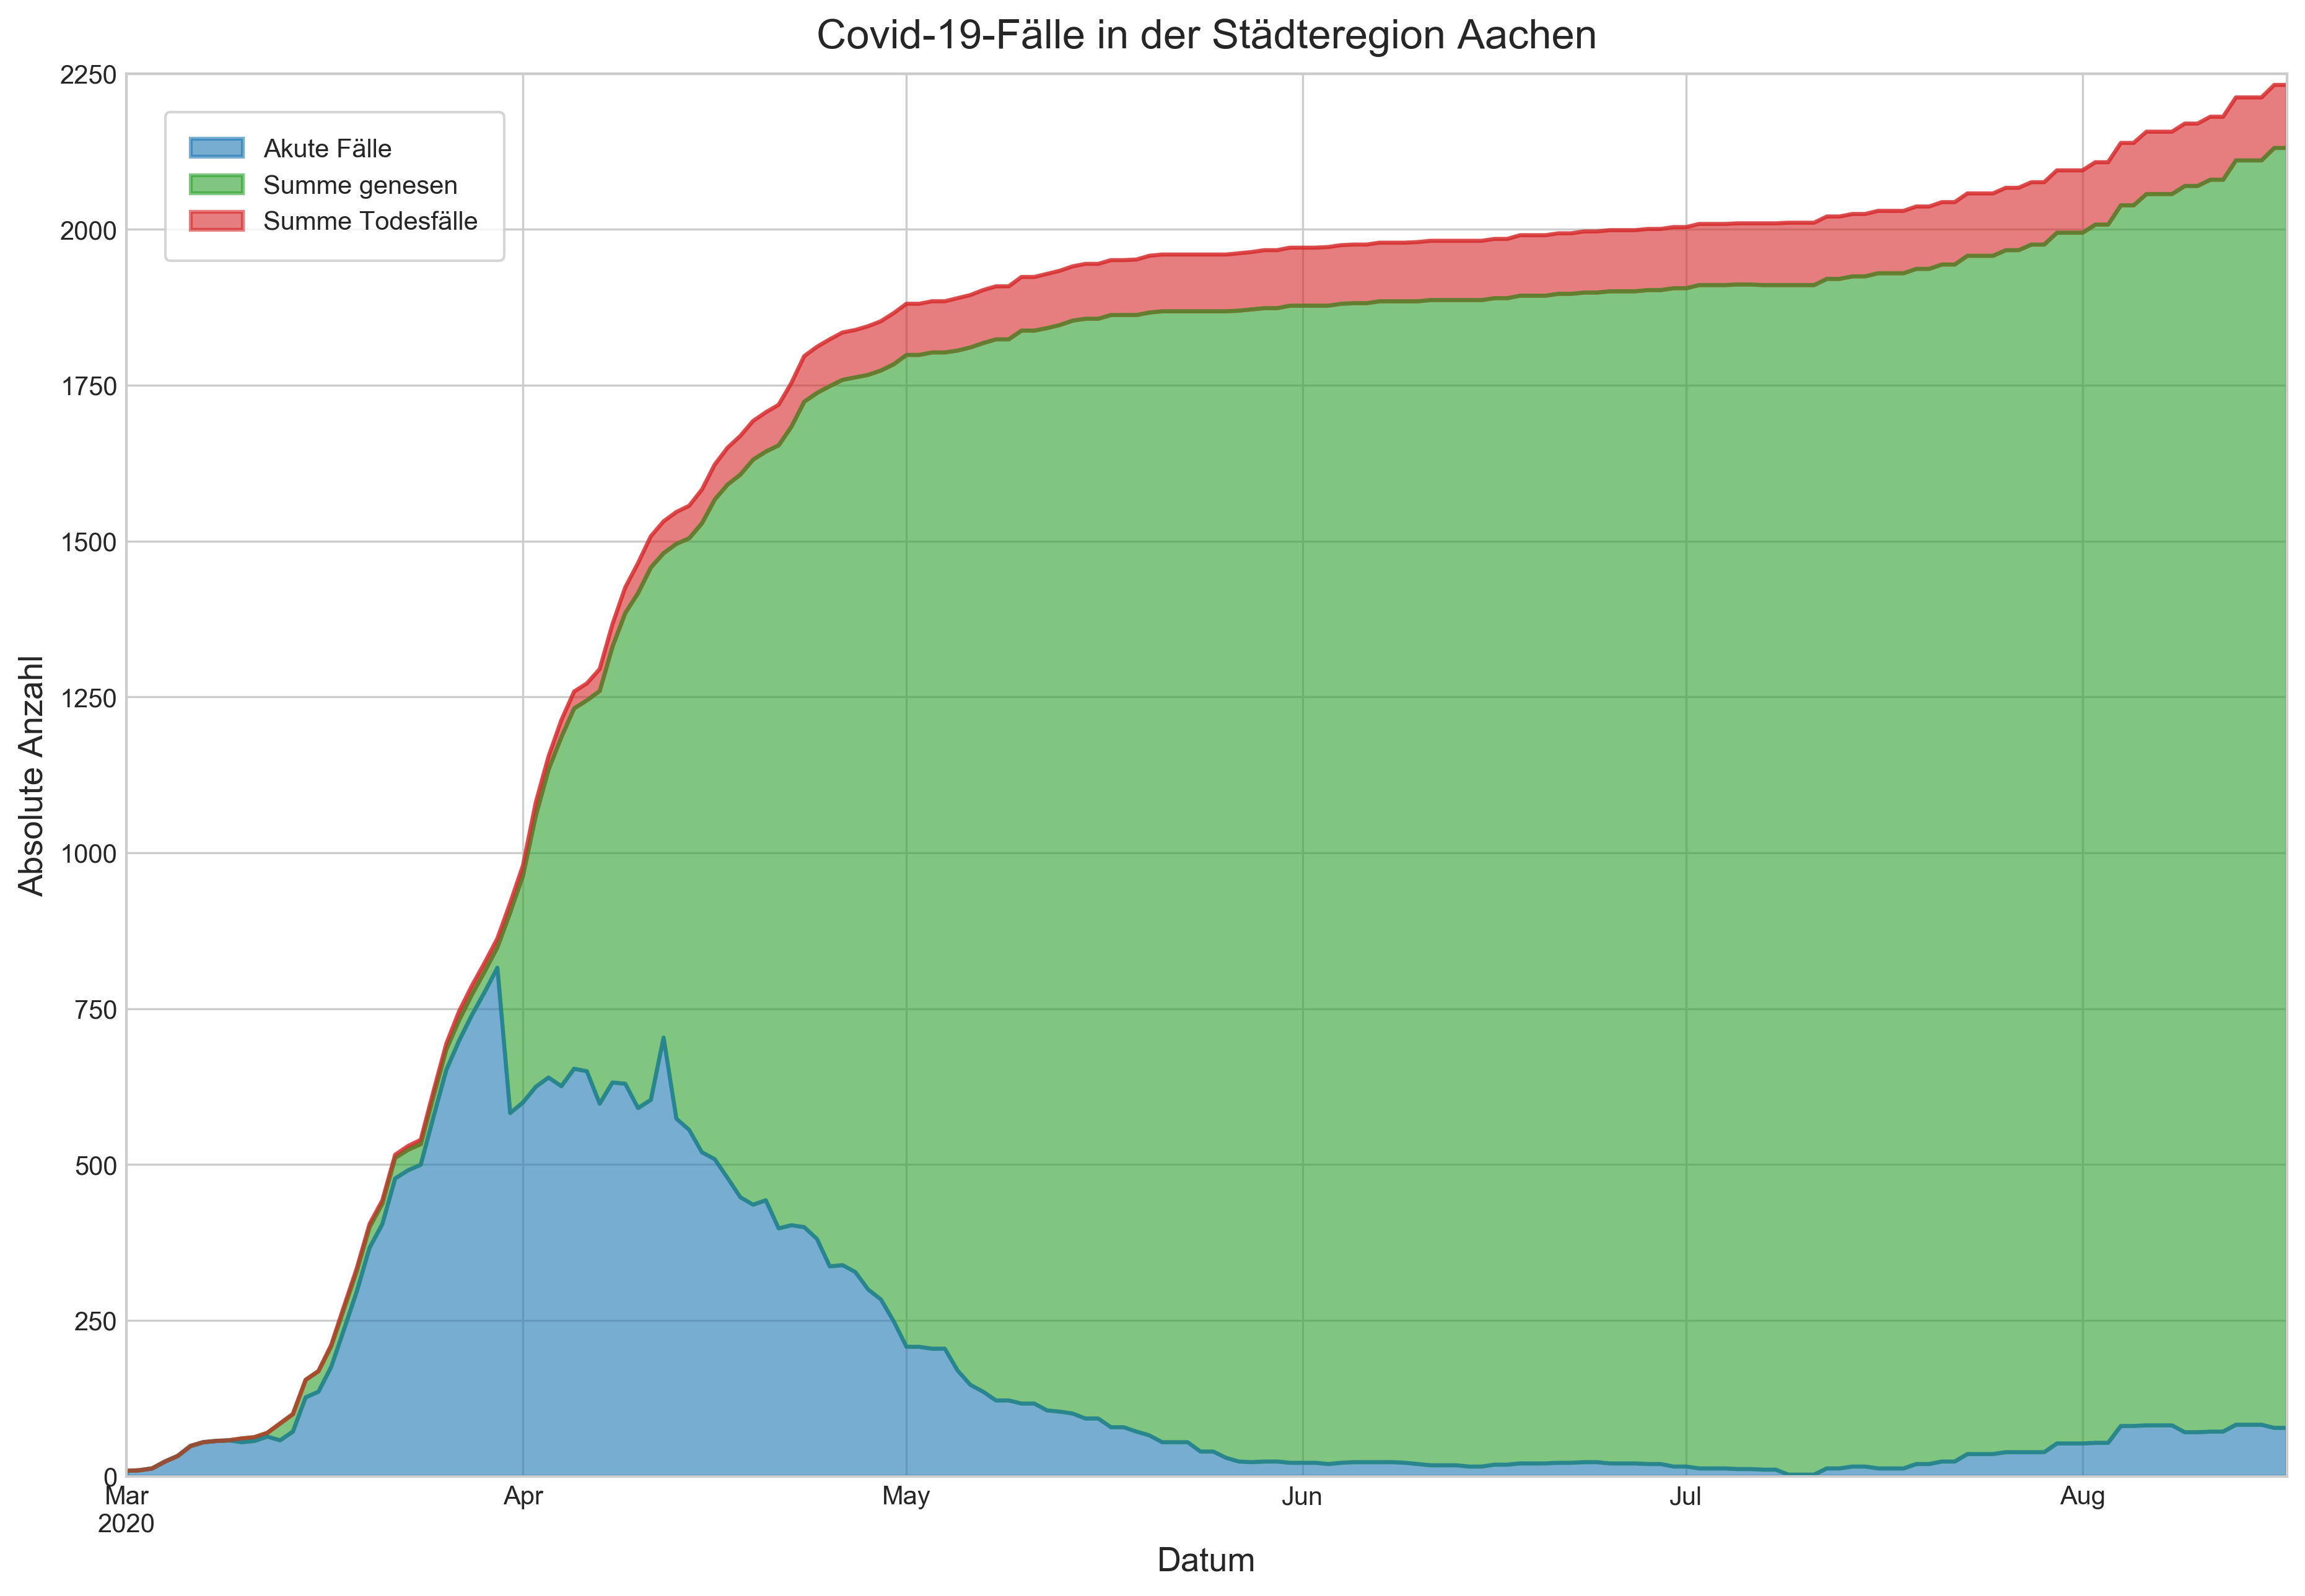

In [5]:
title = 'Covid-19-Fälle in der Städteregion Aachen'

ymax = ((c19_cases['Akute Fälle'] + c19_cases['Summe genesen'] + c19_cases['Summe Todesfälle']).max() // 50 + 1) * 50  

fig = plt.figure()
axes = fig.add_subplot(1,1,1)

ax1 = c19_cases[['Akute Fälle', 'Summe genesen', 'Summe Todesfälle']].plot.area(ax=axes, alpha=0.6, linewidth=1.5, color=color_map_named)

ax1.set_ylim(0, ymax)
ax1.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax1.set_ylabel('Absolute Anzahl')

axes.set_title(title)
axes.grid(b=True, which='major', axis='both')
axes.legend(loc='upper left')
axes.set_xlabel('Datum')

fig.savefig(os.path.join(output_folder, 'c19-kennzahlen-ac-1.jpg'))
file_meta = { "title" : title, "caption": title }
create_meta_file(os.path.join(output_folder, 'c19-kennzahlen-ac-1.jpg.txt'), file_meta)

## 2. Diagramm: Änderung aktiver Fälle

Für die Städteregion Aachen (nur dafür liegen alle benötigten Rohdaten vor) wird die Änderung der aktiven Fälle, absolut und prozentual, pro Tag und gemittelt, visualisiert:

- Eine X-Achse: Zeitachse
- Als Y-Achsen:
    - Achse 1 (links): Änderung der Anzahl aktiver Fälle in absoluten Zahlen (pro Tag und gemittelt)
    - Achse 2 (rechts): Änderung der Anzahl der aktiven Fälle in Prozent (pro Tag und gemittelt)
- Verwendung `df.plot.line()`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.line.html

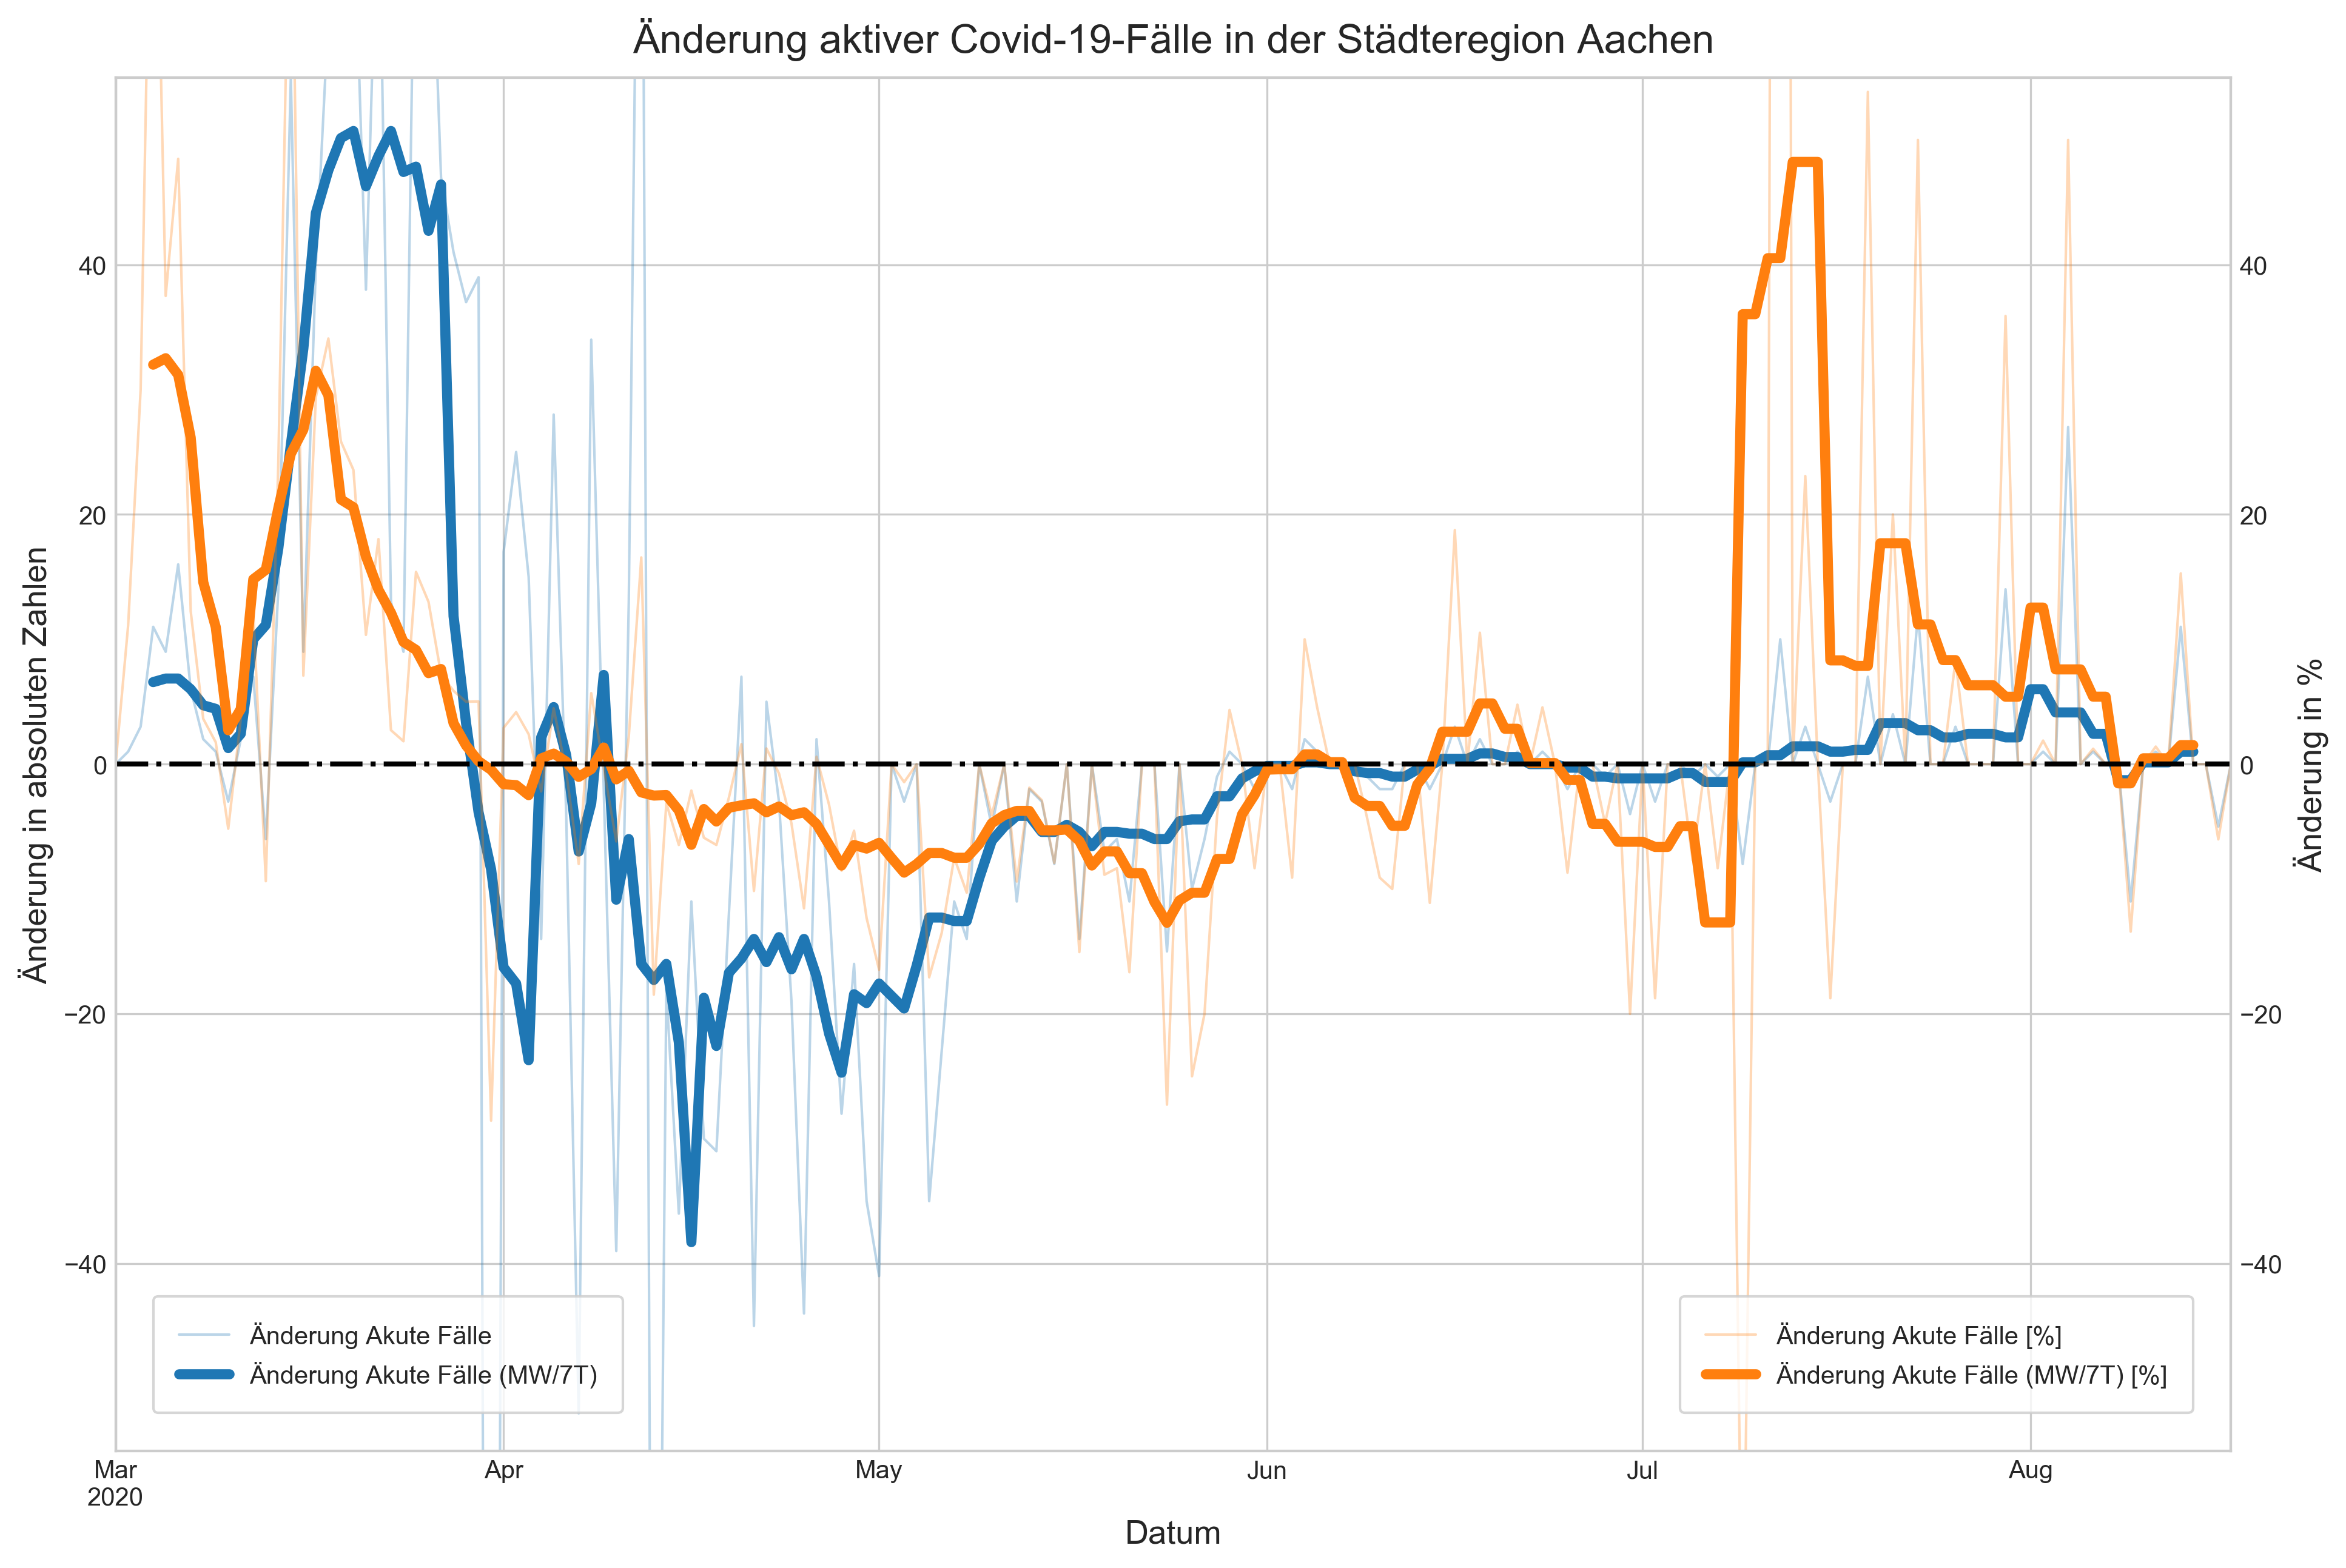

In [6]:
title = 'Änderung aktiver Covid-19-Fälle in der Städteregion Aachen'

columns = [
    'Änderung Akute Fälle',
    'Änderung Akute Fälle (MW/{0}T)'.format(str(Glättungsintervall)),
    'Änderung Akute Fälle [%]',
    'Änderung Akute Fälle (MW/{0}T) [%]'.format(str(Glättungsintervall)) 
]

fig = plt.figure()
axes = fig.add_subplot(1,1,1)

# Berechnung Y-Aachsenskalierung
ymin = (c19_cases[columns[1]].min() // 5 - 1) * 5  
ymax = (c19_cases[columns[1]].max() // 5 + 1) * 5
absmax = max(abs(ymin), abs(ymax))
if absmax < 50:
    absmax = 50
ymin, ymax = -absmax, +absmax

# 1. Achse
ax1 = c19_cases[columns[0]].plot.line(ax=axes, style='-', linewidth=1, color='tab:blue', alpha=0.3)
c19_cases[columns[1]].plot.line(ax=ax1, style='-', linewidth=4, color='tab:blue')

ax1.set_ylim(ymin, ymax)
ax1.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax1.set_ylabel('Änderung in absoluten Zahlen')

# 2. Achse
ax2 = c19_cases[columns[2]].plot.line(ax=axes, secondary_y=True, style='-', linewidth=1, color='tab:orange', alpha=0.3)
c19_cases[columns[3]].plot.line(ax=ax2, secondary_y=True, style='-', linewidth=4, color='tab:orange')

ax2.set_ylim(ymin, ymax)
ax2.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax2.set_ylabel('Änderung in %')
ax2.axhline(y=0, ls='-.', color='black', linewidth=2)

ax1.legend(columns[0:2], loc='lower left')
ax2.legend(columns[2:4], loc='lower right')

axes.set_title(title)
axes.set_xlabel('Datum')
axes.grid(b=True, which='major', axis='both')

fig.savefig(os.path.join(output_folder, 'c19-kennzahlen-ac-2.jpg'))
file_meta = { "title" : title, "caption": title }
create_meta_file(os.path.join(output_folder, 'c19-kennzahlen-ac-2.jpg.txt'), file_meta)

## 3. Diagramm: Neue Fälle / Genesene / Todesfälle

Für die Städteregion Aachen (nur dafür liegen alle benötigten Rohdaten vor) werden die gemittelten Werte neuer Fälle, neuer Genesener und neuer Todesfälle visualisiert (die tagesaktuellen Werte schwanken sehr stark und sind wenig aussagekräftig):

- Eine X-Achse: Zeitachse
- Zwei Y-Achsen:
    - Achse 1 (links): Absolute Anzahl neuer Fälle und wieder Genesener
    - Achse 2 (rechts): Absolute Anzahl neuer Todesfälle

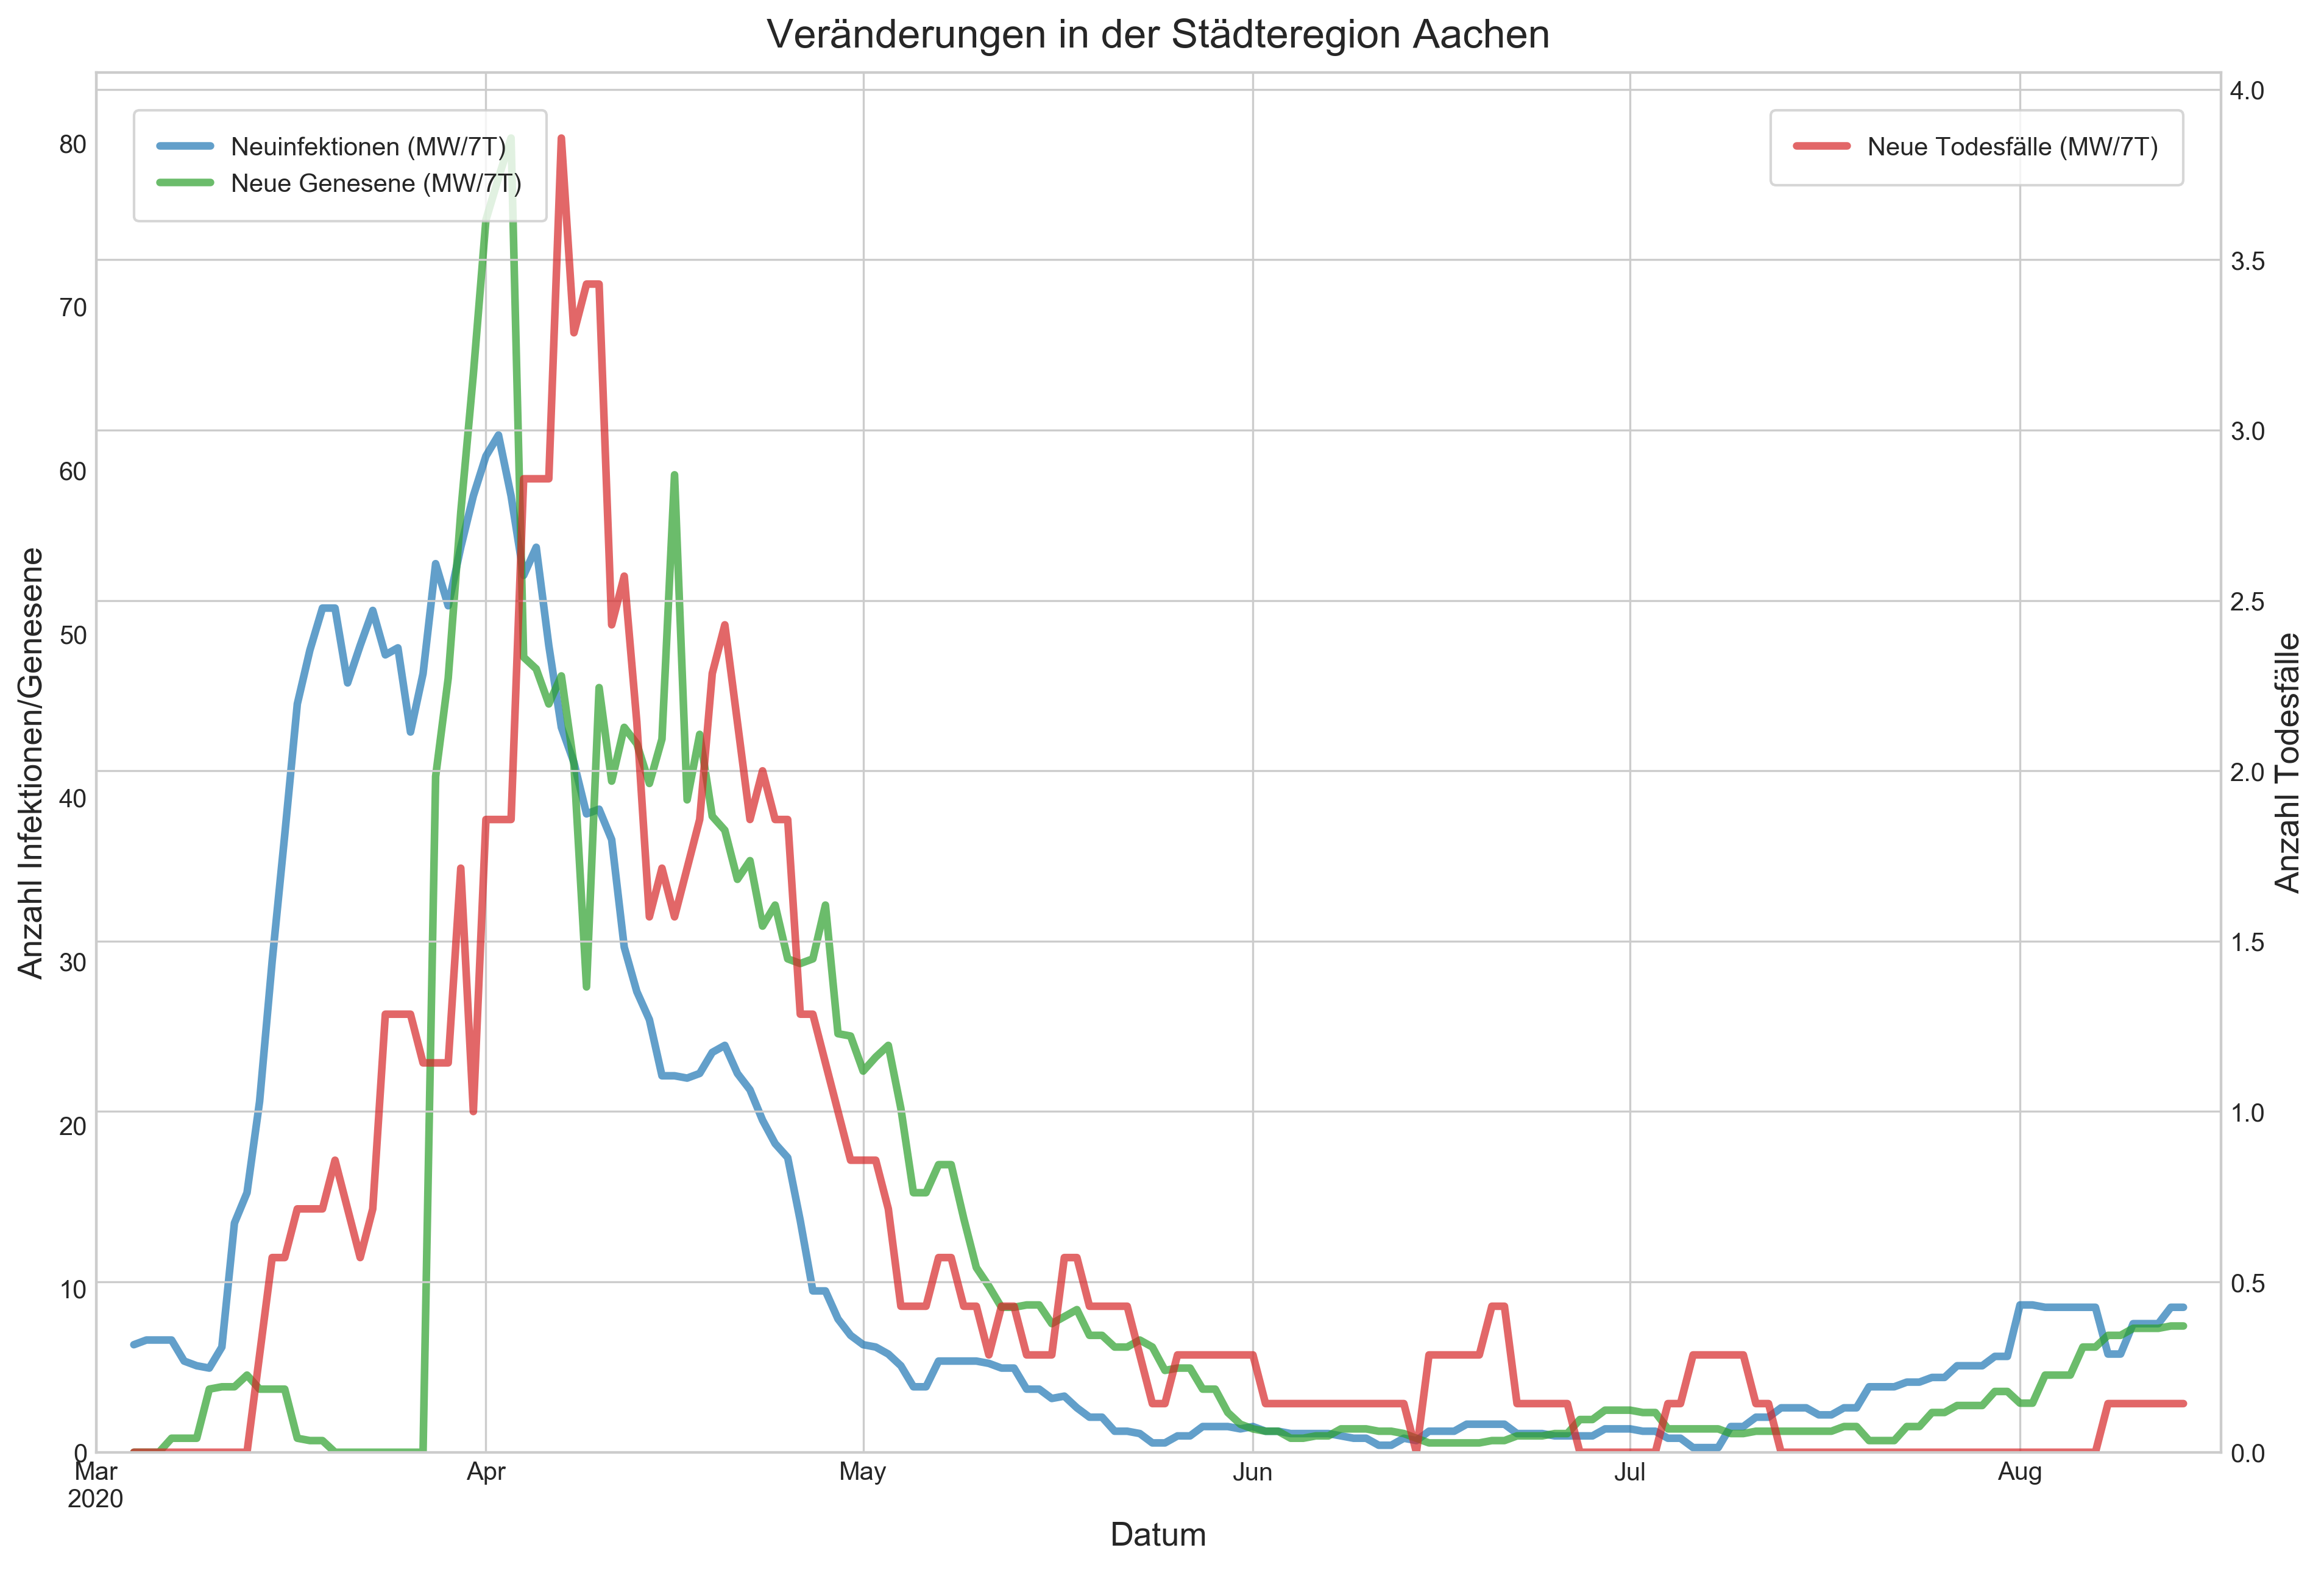

In [7]:
title = 'Veränderungen in der Städteregion Aachen'

fig = plt.figure()
axes = fig.add_subplot(1,1,1)

# 1. Achse
ax1 = c19_cases[['Neuinfektionen (MW/{0}T)'.format(str(Glättungsintervall)), 'Neue Genesene (MW/{0}T)'.format(str(Glättungsintervall))]].plot.line(ax=axes, linewidth=3, alpha=0.7, color=color_map_named[:2])

ax1.set_ylim(0,)
ax1.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax1.set_ylabel('Anzahl Infektionen/Genesene')

# 2. Achse
ax2 = c19_cases[['Neue Todesfälle (MW/{0}T)'.format(str(Glättungsintervall))]].plot.line(ax=axes, secondary_y=True, linewidth=3, alpha=0.7, color=color_map_named[2])

ax2.set_ylim(0,)
ax2.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax2.set_ylabel('Anzahl Todesfälle')

axes.set_title(title)
axes.set_xlabel('Datum', fontsize=13)
axes.grid(b=True, which='major', axis='x')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.savefig(os.path.join(output_folder, 'c19-kennzahlen-ac-3.jpg'))
file_meta = { "title" : title, "caption": title }
create_meta_file(os.path.join(output_folder, 'c19-kennzahlen-ac-3.jpg.txt'), file_meta)

## 4. Diagramm: Neuinfektionen in den letzten 7 Tagen pro 100.000 Einwohner

Für die Städteregion und die Stadt Aachen wird die Summe der Neuinfektionen in den letzten 7 Tagen bezogen auf 100.000 Einwohner dargestellt. Der obere Grenzwert, ab dem neue Maßnahmen ergriffen werden sollen, liegt dafür bei 50 Neuinfektionen in der letzten 7 Tagen pro 100.000 Einwohner:

- Eine X-Achse: Zeitachse
- Eine Y-Achse: Über jeweilse 7 Tage gemittelte Anzahl von Neuinfektionen bezogen auf 100.000 Einwohner und für die Städteregion Aachen wie auch die Stadt Aachen
- Die obere Grenze von 50 Neuinfektionen pro 100.000 Einwohner in den letzen 7 Tagen ist durch eine waagerechte rote Linie gekennzeichnet 

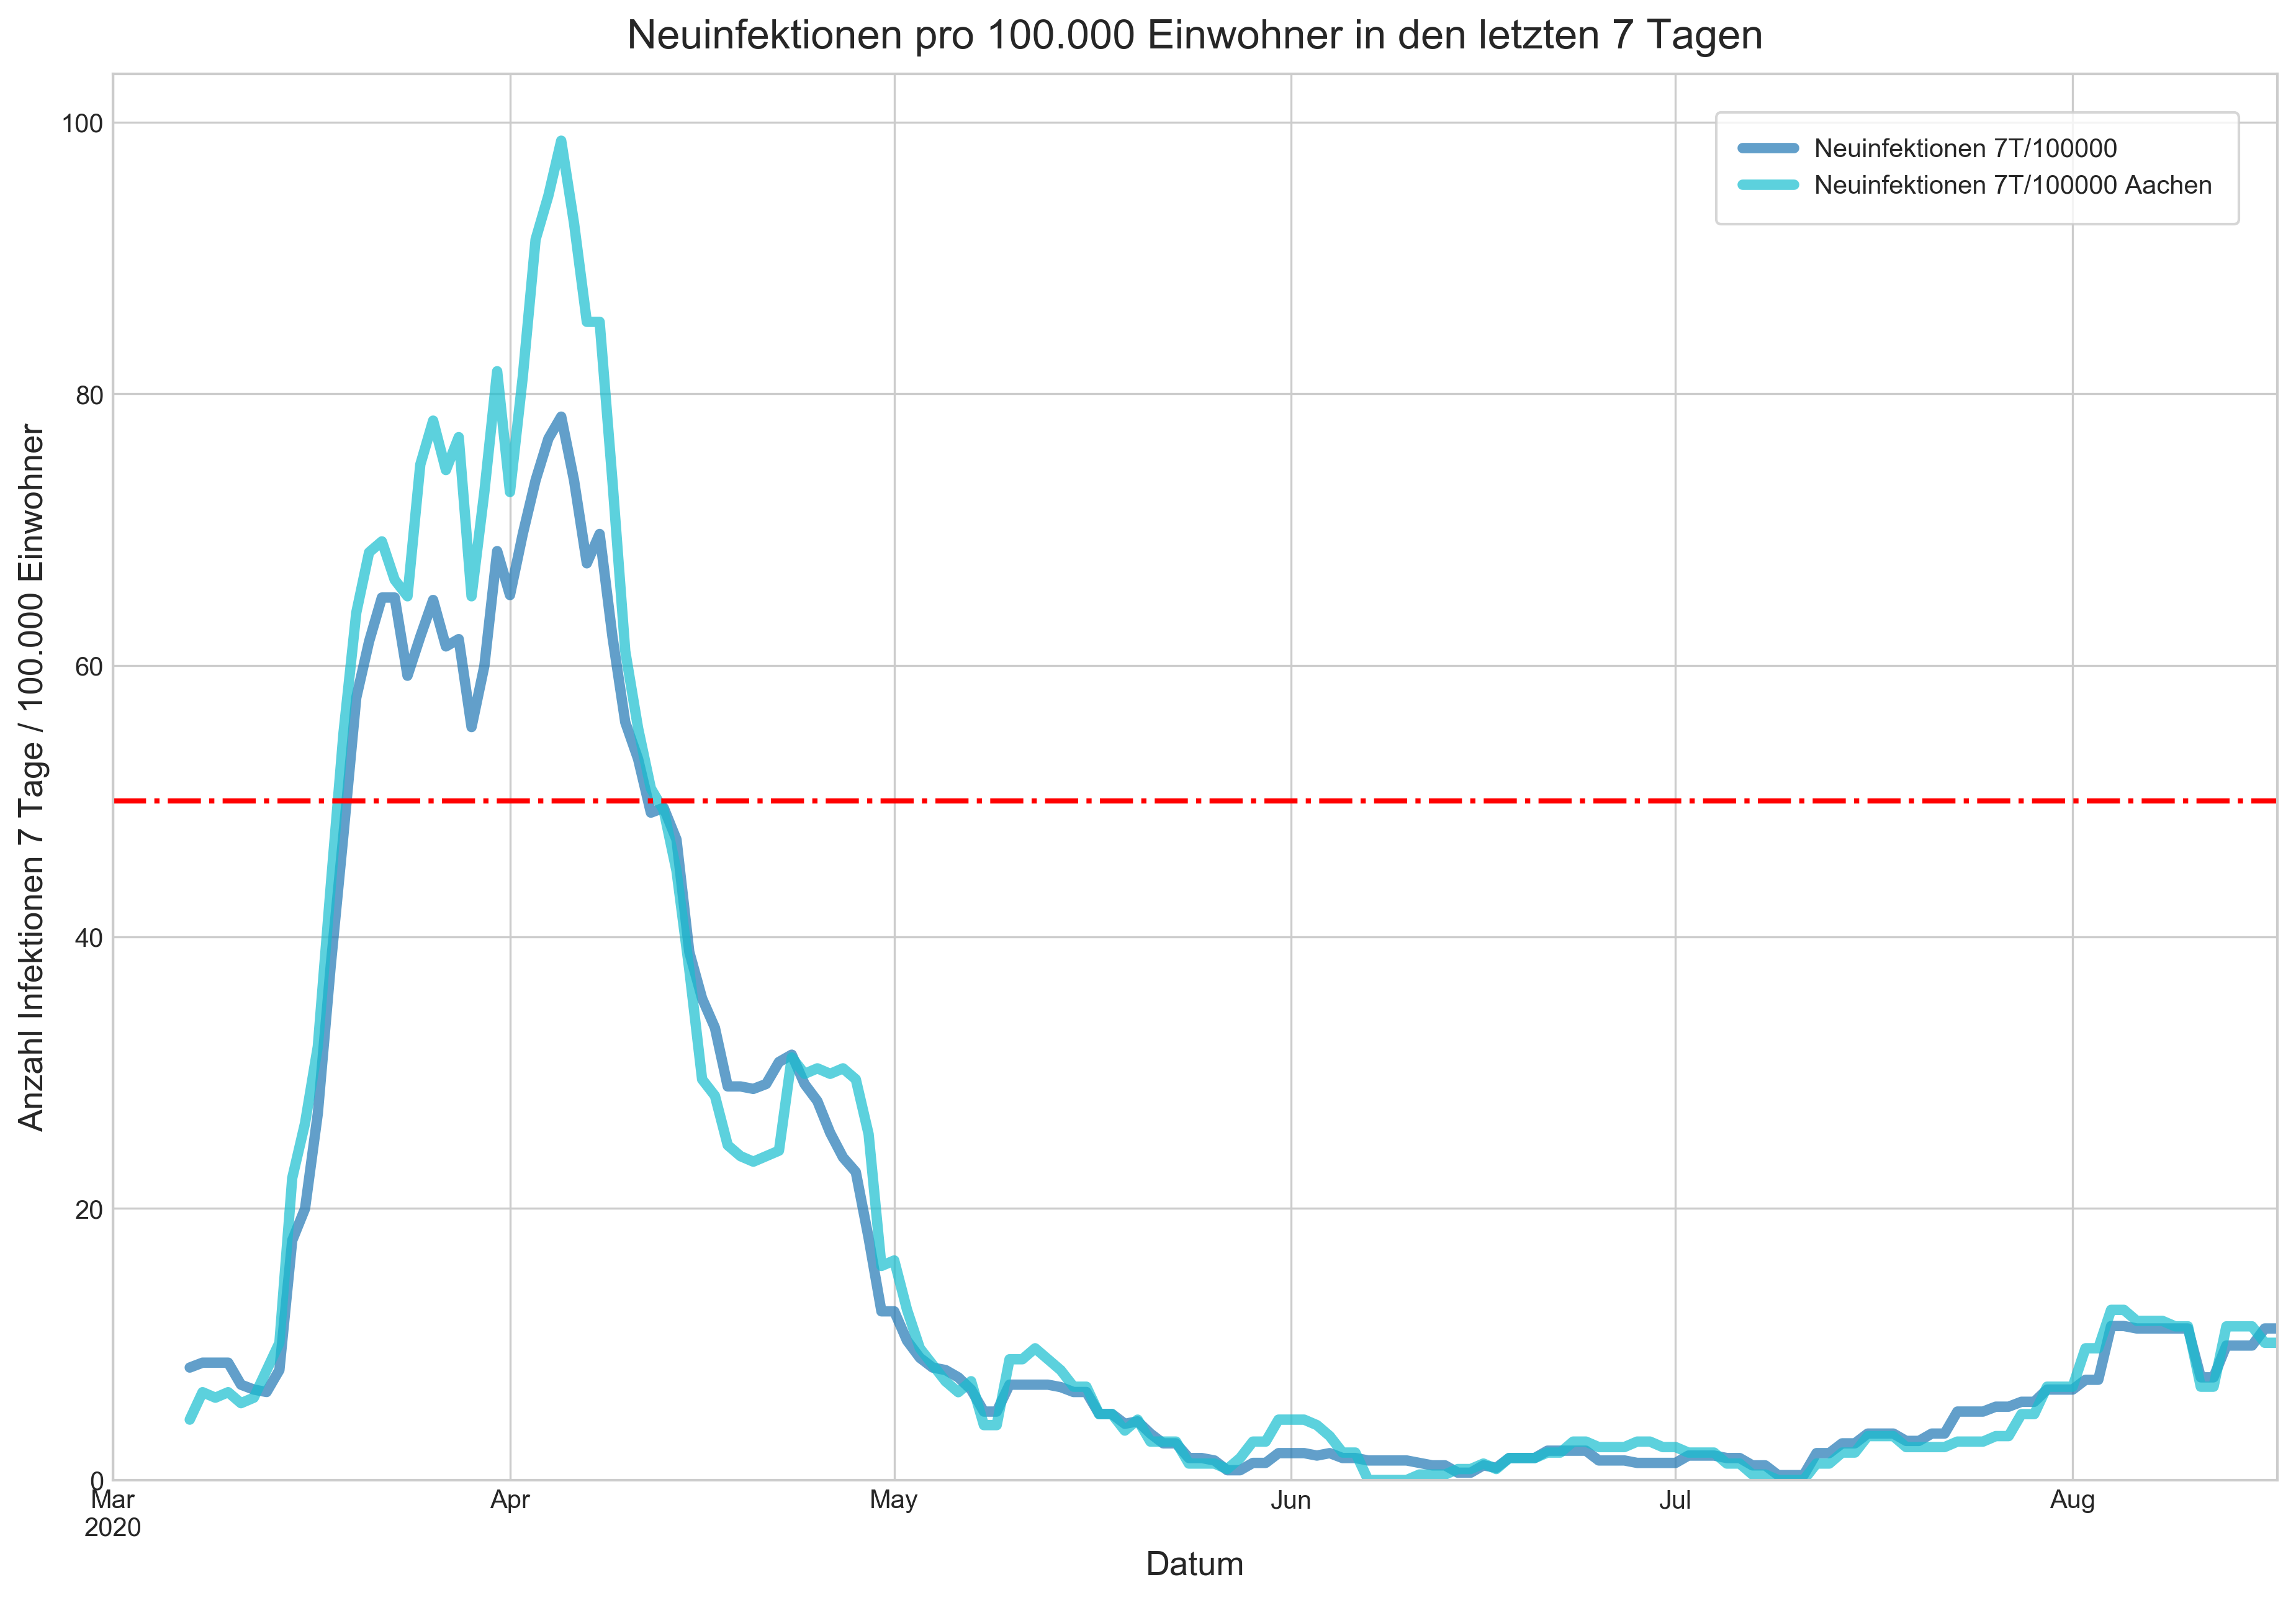

In [8]:
title = 'Neuinfektionen pro 100.000 Einwohner in den letzten 7 Tagen'

fig = plt.figure()
axes = fig.add_subplot(1,1,1)

# 1. Achse
ax1 = c19_cases[['Neuinfektionen 7T/100000', 'Neuinfektionen 7T/100000 Aachen']].plot.line(ax=axes, linewidth=4, alpha=0.7, color=["tab:blue", "tab:cyan"])

ax1.set_ylim(0,)
ax1.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax1.set_ylabel('Anzahl Infektionen 7 Tage / 100.000 Einwohner')

axes.set_title(title)
axes.axhline(y=50, ls='-.', color='r', linewidth=2)
axes.legend(loc='upper right')
axes.grid(b=True, which='major', axis='both')
axes.set_xlabel('Datum')

fig.savefig(os.path.join(output_folder, 'c19-kennzahlen-ac-4.jpg'))
file_meta = { "title" : title, "caption": title }
create_meta_file(os.path.join(output_folder, 'c19-kennzahlen-ac-4.jpg.txt'), file_meta)